In [146]:
import matplotlib.pyplot as plt
import numbers
import numpy as np
import scipy
from scipy.integrate import quad
from scipy import optimize
from scipy import stats

Notes/questions/to-do
* In the case of $f \sim 10^{-4} - 10^{-2}$, which is more constraining: $\gamma$-ray point source or diffuse constraints? When can each be used?
* Need to make sure the detectable PBHs aren't too close to Earth! **Otherwise they could contribute to the local DM density.**

In [147]:
kpc_to_cm = 3.086e21  # 1 kpc in cm
cm_to_kpc = 1 / kpc_to_cm
GeV_to_m_sun = 1 / 1.11543e57
m_sun_to_GeV = 1 / GeV_to_m_sun
GeV_to_erg = 0.001602
erg_to_GeV = 1 / GeV_to_erg
yr_to_s = 365. * 24 * 60**2
s_to_yr = 1 / yr_to_s
L_sun_to_GeV_s = 2.402e36
GeV_s_to_L_sun = 1 / L_sun_to_GeV_s
L_sun_to_erg_s = L_sun_to_GeV_s * GeV_to_erg
erg_s_to_L_sun = 1 / L_sun_to_erg_s

# Milky Way halo's virial radius, assuming an NFW profile
r_vir_mw_nfw = 8.28862681e11  # kpc
r_s_mw_nfw = 24.42  # kpc
# Sampling from this is EXTREMELY slow!
r_dist_nfw = stats.gausshyper(2, 1, 2, r_vir_mw_nfw/r_s_mw_nfw, scale=r_vir_mw_nfw)

# Best-fit Einasto parameters for Milky Way halo. From PPPC.
# alpha_mw = 0.17
# r_s_mw = 28.44  # kpc
alpha_mw=0.25
r_s_mw = 4.5  # kpc   # for comparison with Gf+Zentner
rho_e_mw = 0.033 * GeV_to_m_sun / cm_to_kpc**3  # M_sun / kpc^3

def rho_einasto(r, rho_e, r_s, alpha):
    """Einasto density profile."""
    return rho_e * np.exp(-2/alpha * ((r / r_s)**alpha - 1))

# Corresponding probability distributions for coordinates. Cross-checked with r**2 * rho_einasto.
r_dist = stats.gengamma(a=3/alpha_mw, c=alpha_mw, loc=0,
                        scale=(alpha_mw/2)**(1/alpha_mw) * r_s_mw)
cos_th_dist = stats.uniform(-1., 2.)
phi_dist = stats.uniform(0, 2*np.pi)
def r_sample(n):
    return np.random.gamma(shape=3/alpha_mw, scale=alpha_mw*r_s_mw**alpha_mw/2,
                           size=n)**(1/alpha_mw)
def cos_th_sample(n):
    return np.random.uniform(-1., 1., n)
def phi_sample(n):
    return np.random.uniform(0., 2*np.pi, n)

# Total MW DM mass in M_sun. Cross-checked with PPPC.
m_mw_dm = quad(lambda r: 4*np.pi*r**2*rho_einasto(r, rho_e_mw, r_s_mw, alpha_mw),
               0., np.inf, epsabs=0, epsrel=1e-4)[0]

Omega_cdm = 0.2589  # from Planck 2015
z_eq = 3500.
z_final = 30.  # redshift at which to end PBH halo evolution
d_earth = 8.33  # kpc
age_of_universe = 13e9  # yr
fermi_psf = 0.15 * np.pi / 180.  # arxiv:0902.1089
fermi_psf_solid_angle = 2.*np.pi*(1. - np.cos(fermi_psf))
# Particle physics
alpha_em = 1/137.
m_e = 0.511e-3  # GeV
m_mu = 105.7e-3  # GeV
m_tau = 1.776  # GeV

def integral_e_dnde(m_dm, e_low, e_high, fs="g g"):
    """Computes the energy flux, int dE E dN/dE.
    
    Notes
    -----
    Uses the Altarelli-Parisi approximation for FSR from leptons.
    
    Parameters
    ----------
    m_dm
        DM mass, GeV.
    e_low, e_high
        Energy interval, GeV.
    fs : string
    
    Returns
    -------
    Energy flux per annihilation, GeV.
    """
    if fs == "g g":
        if e_low <= m_dm <= e_high:
            return 2.*m_dm
        else:
            return 0.
    elif fs == "e e":
        return alpha_em/np.pi * (e_high - e_low) * np.log(4*m_dm/m_e)
    elif fs == "mu mu":
        return alpha_em/np.pi * (e_high - e_low) * np.log(4*m_dm/m_mu)
    elif fs == "tau tau":
        return alpha_em/np.pi * (e_high - e_low) * np.log(4*m_dm/m_tau)
    else:
        raise ValueError("Unknown final state")
        
def integral_dnde(m_dm, e_low, e_high, fs="g g"):
    """Computes the integrated spectrum, int dE dN/dE.
    
    Notes
    -----
    Uses the Altarelli-Parisi approximation for FSR from leptons.
    
    Parameters
    ----------
    m_dm
        DM mass, GeV.
    e_low, e_high
        Energy interval, GeV.
    fs : string
    
    Returns
    -------
    Integrated photon flux per annihilation, GeV.
    """
    if fs == "g g":
        if e_low <= m_dm <= e_high:
            return 2.
        else:
            return 0.
    elif fs == "e e":
        return alpha_em/np.pi * np.log(e_high / e_low) * np.log(4*m_dm/m_e)
    elif fs == "mu mu":
        return alpha_em/np.pi * np.log(e_high / e_low) * np.log(4*m_dm/m_mu)
    elif fs == "tau tau":
        return alpha_em/np.pi * np.log(e_high / e_low) * np.log(4*m_dm/m_tau)
    else:
        raise ValueError("Unknown final state")

def to_galactic_coords(r, th, phi, deg=True):
    """Converts from spherical coordinates centered on the GC to galactic coordinates."""
    x = r * np.sin(th) * np.cos(phi)
    y = r * np.sin(th) * np.sin(phi)
    z = r * np.cos(th)
    
    d = np.sqrt((x - d_earth)**2 + y**2 + z**2)
    b = np.pi/2 - np.arccos(z / d)
    l = np.arctan2(y, x - d_earth)
    
    if deg:
        return np.stack([d, 180/np.pi*b, 180/np.pi*l])
    else:
        return np.stack([d, b, l])

In [114]:
m_dm_gf = 100.  # GeV
e_gf, dnde_gf = np.loadtxt("data/dnde_bb_gf.csv").T
e_gf *= m_dm_gf
dnde_gf /= m_dm_gf

dnde_gf_interp = scipy.interpolate.interp1d(e_gf, dnde_gf, bounds_error=False,
                                            fill_value=0.)
dnde_int_gf = scipy.integrate.quad(dnde_gf_interp, 0., m_dm_gf, epsabs=1e-99)

def integral_dnde_gf(m_dm=100., e_low=1., e_high=100., fs="b b"):
    return dnde_int_gf[0]

/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  


In [142]:
class PBHHaloSim(object):
    def __init__(self, mass_dist, f_pbh, m_dm=100, sv=3e-26, e_low=1, e_high=100,
                 fs="g g", dOmega=fermi_psf_solid_angle, b_cut=10, flux_thresh=4e-13):
        self.mass_dist = mass_dist
        self.f_pbh = f_pbh
        self.m_dm = m_dm
        self.sv = sv
        self.e_low = e_low
        self.e_high = e_high
        self.fs = fs
        self.dOmega = dOmega
        self.b_cut = b_cut
        self.flux_thresh = flux_thresh  # erg / cm^2 / s
        
    def r_samples(self, n=None):
        if n is None:
            n = self.n_samples
        return np.random.gamma(shape=3/alpha_mw,
                               scale=alpha_mw*r_s_mw**alpha_mw/2,
                               size=n)**(1/alpha_mw)
    
    def th_samples(self):
        return np.arccos(np.random.uniform(-self.slat_ms, self.slat_ms))
    
    def phi_samples(self):
        return np.random.uniform(-self.phi_ms, self.phi_ms)
    
    def _gen_positions(self):
        self.positions = np.stack([r_sample(self.n_samples),
                                   self.th_samples(),
                                   self.phi_samples()])
        self.positions = to_galactic_coords(*self.positions)
        
    def _pbh_halo_ann_rates(self):
        """
        Notes
        -----
        From Byrnes2019.

        Returns
        -------
        UCMH annihilation rate in 1/s.
        """
        rho_max = self.m_dm / (self.sv * age_of_universe * yr_to_s)
        r_cut = 1.3e-7 * (100./self.m_dm * self.sv/3e-26)**(4/9) * (self.m_pbhs/1.)**(1/3)
        units_factor = kpc_to_cm**3
        # Added missing factor of 1/2
        return 4*np.pi*self.sv*rho_max**2 * r_cut**3 / (2*self.m_dm**2) * units_factor
    
    def _gen_pbh_halos(self):
        if isinstance(self.mass_dist, numbers.Number):
            self.m_pbhs = self.mass_dist * np.ones(self.n_samples)
            self.ann_rates = self._pbh_halo_ann_rates()
            # Number of PBHs in the Milky Way halo
            self.num_halo_pbhs = self.f_pbh * m_mw_dm / np.mean(self.m_pbhs)
        else:
            raise ValueError("Extended PBH mass functions are not supported yet")

    def _energy_fluxes(self, d):
        """Computes energy flux in 1 / cm^2 / s.
        """
#         int_specs = integral_e_dnde(self.m_dm, self.e_low, self.e_high, self.fs)
#         return self.ann_rates / (4*np.pi*(d*kpc_to_cm)**2) * int_dnde
        int_dnde = integral_dnde_gf()
        return 9e-10 * int_dnde / d**2 * self.sv / 1e-26
    
    def _num_detectable_pbh_halos(self, b_cut=None, flux_thresh=None):
        if b_cut is not None:
            self.b_cut = b_cut
        if flux_thresh is not None:
            self.flux_thresh = flux_thresh
        # PBHs outside galactic plane
        self.passed_b_cut_idx = np.abs(self.positions[1]) > self.b_cut
        # PBHs above energy threshold
        self.passed_e_thresh_idx = self.e_fluxes > self.flux_thresh
        # Values in this array are set to one for PBHs passing all cuts
        self.passed_cuts = np.zeros(self.n_samples)
        self.passed_cuts[self.passed_b_cut_idx & self.passed_e_thresh_idx] = 1.
        # Correct for sampling over particular solid angles
        self.passed_cuts *= self.pr_solid_angle_correction
        # Probability for a PBH in the MW halo to pass all cuts
        self.pr_passed_cuts = np.mean(self.passed_cuts)
        # 95% confidence interval on estimate of this probability
        self.pr_passed_cuts_err = 1.96 * np.std(self.passed_cuts) / np.sqrt(self.n_samples)
        # MC estimate for number of detectable PBHs in MW halo
        self.num_detectable_pbhs = self.num_halo_pbhs * self.pr_passed_cuts
        self.num_detectable_pbhs_err = self.num_halo_pbhs * self.pr_passed_cuts_err
        return self.num_detectable_pbhs
    
    def _get_angular_dist_bounds(self, efficient_angular_sampling=False):
        """Determines bounds to be used for generating each PBH's angular coordinates
        """
        if efficient_angular_sampling:
            # Compute max distance from Earth at which PBH could be detected by Fermi
            self.d_ms = np.sqrt(self._energy_fluxes(1) / self.flux_thresh)
            self.slat_ms = np.ones_like(self.d_ms)  # sin of latitude from galactic plane
            self.phi_ms = np.pi * np.ones_like(self.d_ms)
            self.slat_ms[self.d_ms < d_earth] = self.d_ms[self.d_ms < d_earth] / d_earth
            self.phi_ms[self.d_ms < d_earth] = np.arcsin(
                self.d_ms[self.d_ms < d_earth] / d_earth)
            # Determine correction for probability, making use of the fact that th_m can
            # never be larger than pi, so cos(th_m) >= 1
            self.pr_solid_angle_correction = 4*self.slat_ms * self.phi_ms / (4*np.pi)
        else:
            self.slat_ms = np.ones(self.n_samples)
            self.phi_ms = np.pi * np.ones(self.n_samples)
            self.pr_solid_angle_correction = np.ones(self.n_samples)
    
    def run(self, n_samples):
        if not isinstance(self.mass_dist, numbers.Number):
            raise ValueError("Extended PBH mass functions are not supported yet")
            
        self.n_samples = n_samples
        self._gen_pbh_halos()
        self._get_angular_dist_bounds()  # must run before _gen_positions(), after _gen_pbh_halos()!
        self._gen_positions()
        self.e_fluxes = self._energy_fluxes(self.positions[0])
        self._num_detectable_pbh_halos()
        return self.num_detectable_pbhs

Validating against Gf + Zentner

In [143]:
sim = PBHHaloSim(mass_dist=1e5, f_pbh=3.16e-6, m_dm=100., sv=3e-26)
print("# det PBHs = {} +/- {}".format(sim.run(300000), sim.num_detectable_pbhs_err))

# det PBHs = 0.16459351934407285 +/- 0.0003352353068850799


In [144]:
n_det_pbhs = []
flux_threshs = np.logspace(-13, -3)

for flux_thresh in flux_threshs:
    sim = PBHHaloSim(mass_dist=1e6, f_pbh=0.009*1.6, m_dm=100., sv=3e-26,
                     flux_thresh=flux_thresh, b_cut=10.)
    n_det_pbhs.append(sim.run(300000))

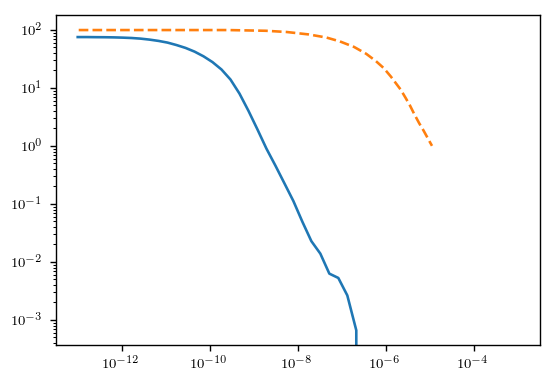

In [145]:
flux_threshs_gf, n_det_pbhs_gf = np.loadtxt("data/n_det_pbhs_gf.csv").T

plt.loglog(flux_threshs, n_det_pbhs)
plt.loglog(flux_threshs_gf, n_det_pbhs_gf, '--')

Use clever sampling trick

In [4]:
sim = PBHHaloSim(mass_dist=10., f_pbh=1e-3, m_dm=100., sv=1e-45)
print("# det PBHs = {} +/- {}".format(sim.run(3000000), sim.num_detectable_pbhs_err))

# det PBHs = 3097.6322320005197 +/- 78.96460066944367


In [7]:
# sim = PBHHaloSim(mass_dist=30., f_pbh=2e-9, m_dm=100., sv=3e-40)
sim = PBHHaloSim(mass_dist=0.5, f_pbh=1e-3, m_dm=100., sv=1e-40)
print("# det PBHs = {} +/- {}".format(sim.run(3000000), sim.num_detectable_pbhs_err))

# det PBHs = 221853.8970868753 +/- 4558.416085340868


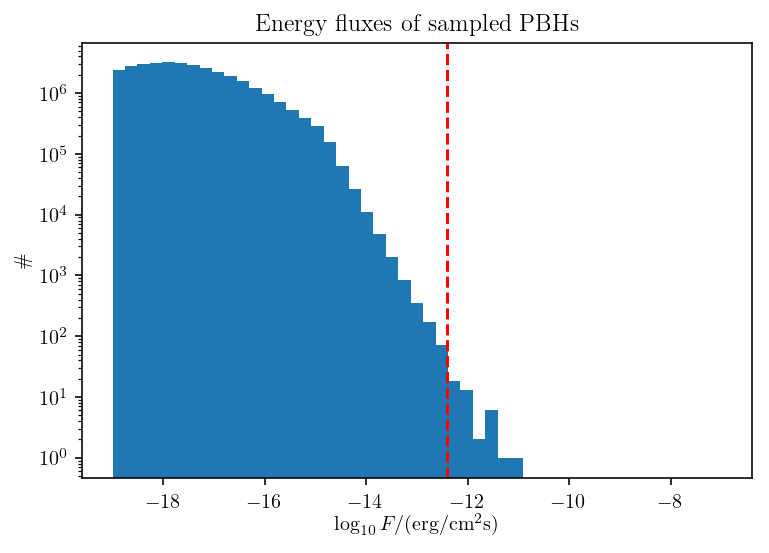

In [126]:
plt.hist(np.log10(sim.e_fluxes), bins=np.linspace(-19, -7))
plt.axvline(np.log10(sim.e_flux_thresh), color='r', linestyle='--')

plt.title("Energy fluxes of sampled PBHs")
plt.xlabel(r"$\log_{10} F / (\mathrm{erg}/\mathrm{cm}^2\mathrm{s})$")
plt.ylabel("\#")
plt.yscale("log")

Only need to scan over $(m_\chi, \langle \sigma v \rangle)$ grid since $N_{\mathrm{obs}}^{\gamma-\mathrm{srcs}}$ scales as $f_{\mathrm{PBH}}$!

In [157]:
m_pbhs = np.logspace(-1, 2, 25)
n_det_pbhs = []
n_det_pbhs_err = []
for m_pbh in m_pbhs:
    sim = PBHHaloSim(mass_dist=m_pbh, f_pbh=5e-9, m_dm=100., sv=3e-26)
    n_det_pbhs.append(sim.run(1000000))
    n_det_pbhs_err.append(sim.num_detectable_pbhs_err)
n_det_pbhs = np.array(n_det_pbhs)
n_det_pbhs_err = np.array(n_det_pbhs_err)

Text(0.5, 1.0, '$f_{\\mathrm{PBH}} = 10^{-9}$, $m_{\\mathrm{DM}}=100$ GeV, $\\langle \\sigma v \\rangle = 3\\times 10^{-26}$ cm$^3$/s, $E_{\\mathrm{thresh}}=4\\times 10^{-13}$ erg/s')

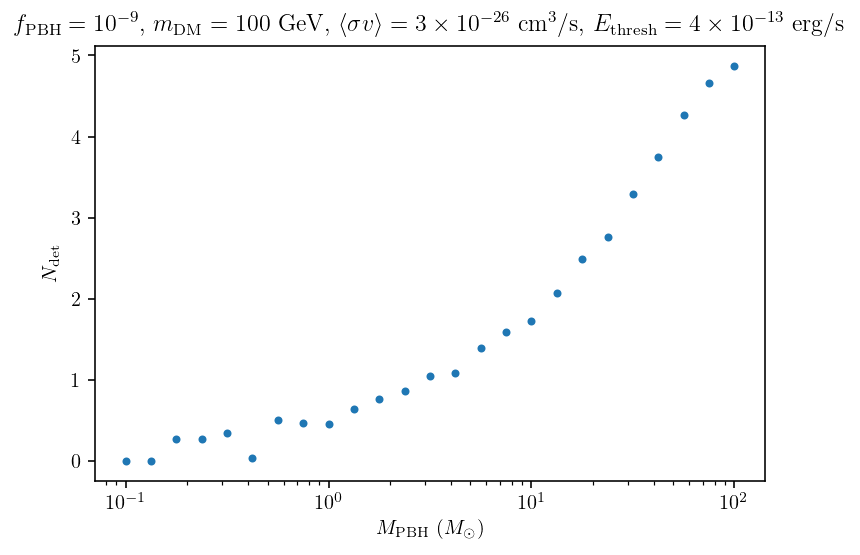

In [159]:
plt.errorbar(m_pbhs, n_det_pbhs, yerr=n_det_pbhs_err, fmt='.')
plt.xscale("log")
# plt.yscale("log")
plt.xlabel(r"$M_{\mathrm{PBH}}$ ($M_\odot$)")
plt.ylabel(r"$N_{\mathrm{det}}$")
plt.title(r"$f_{\mathrm{PBH}} = 10^{-9}$, $m_{\mathrm{DM}}=100$ GeV, "
          r"$\langle \sigma v \rangle = 3\times 10^{-26}$ cm$^3$/s, $E_{\mathrm{thresh}}=4\times 10^{-13}$ erg/s")

Comparison with Visinelli's paper

In [10]:
num_anns = []
m_pbhs = np.logspace(-18, -4)

for m in m_pbhs:
    sim = PBHHaloSim(m, f_pbh=1, m_dm=10e3)
    sim.run(1)
    num_anns.append(sim._pbh_halo_ann_rates())# * erg_to_GeV / sim.m_dm)
num_anns = np.array(num_anns)

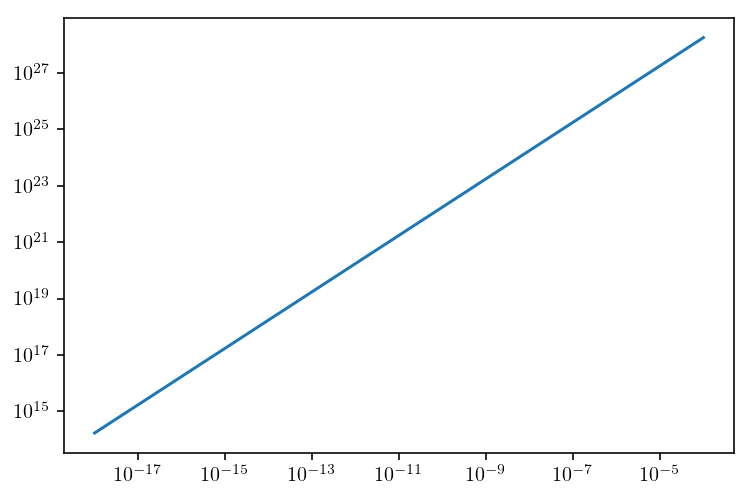

In [11]:
plt.loglog(m_pbhs, num_anns)

Byrnes' gamma-ray constraints. I find that he's over-optimistic by a factor of 1/3.

In [30]:
def constrain_f_pbh(m_pbh, m_dm=100, sv=3e-26):
    # Replicate Byrnes2019 constraints
    rho_max = m_dm / (sv * age_of_universe * yr_to_s)
    # kpc
    r_cut = (sv / 3e-26)**(4/9) * (m_dm / 100)**(-4/9) * (m_pbh / 1.)**(1/3) * 1.3e-7
    Gamma_pbh = 4*np.pi*sv*rho_max**2*r_cut**3 / m_dm**2 * kpc_to_cm**3
    Gamma_dm = 1e-28  # 1/s
    return Gamma_dm/Gamma_pbh * m_pbh*m_sun_to_GeV/m_dm

Text(0.5, 1.0, '$M_{\\mathrm{PBH}} = 30 M_\\odot$')

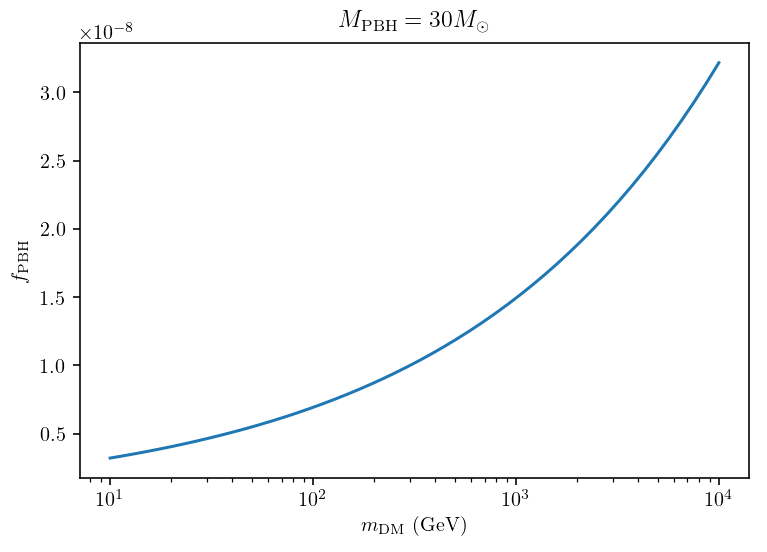

In [31]:
m_dms = np.logspace(1, 4)

plt.plot(m_dms, [constrain_f_pbh(30., m_dm) for m_dm in m_dms])
plt.xscale("log")

plt.xlabel(r"$m_{\mathrm{DM}}$ (GeV)")
plt.ylabel(r"$f_{\mathrm{PBH}}$")
plt.title(r"$M_{\mathrm{PBH}} = 30 M_\odot$")

# Notes: point sources vs diffuse

Plugging in $M_{\mathrm{PBH}} = 30 M_\odot$, $f=10^{-8}$ and assuming a uniform angular distribution, we can compute the average angular radius around each PBH that does not contain another PBH. This angle is 50 times larger than Fermi's PSF. Since in reality sources are not uniformly distributed on the sky, this is a bit of an underestimate. **This means Byrnes' analysis is inconsistent: at such low $f$s, you need to perform a point source analysis to properly constrain $f$.**

In [57]:
n_pbhs_in_mw = 1e-8*(m_mw_dm / 30.)
avg_pbh_angular_sep = 2*np.sqrt((4*np.pi / n_pbhs_in_mw) / np.pi) / fermi_psf
print("<th_sep> / fermi_psf = %f" % avg_pbh_angular_sep)

<th_sep> / fermi_psf = 47.036560


Let's instead consider $f = 10^{-3}$ and $M_{\mathrm{PBH}} = 0.5 M_\odot$, which are interesting numbers for LIGO O3. In this case the average separation is much smaller than Fermi's PSF. This means the DM self-annihilation cross section must be very small for a point source search to be valid.

In [58]:
n_pbhs_in_mw = 1e-3*(m_mw_dm / 0.5)
avg_pbh_angular_sep = 2*np.sqrt((4*np.pi / n_pbhs_in_mw) / np.pi) / fermi_psf
print("<th_sep> / fermi_psf = %f" % avg_pbh_angular_sep)

<th_sep> / fermi_psf = 0.019203


# Multiprocessing

In [5]:
import multiprocessing as mp

In [40]:
def cube(x):
    return x**3

pool = mp.Pool(processes=4)
results = [pool.apply(cube, args=(x,)) for x in range(1, 7)]

results

[1, 8, 27, 64, 125, 216]

Process ForkPoolWorker-21:
Process ForkPoolWorker-19:
Process ForkPoolWorker-18:
Process ForkPoolWorker-20:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/multiprocessing/process.py", line 9

In [52]:
n_samples = 10000000
positions = np.stack([r_dist.rvs(n_samples),
                      np.arccos(cos_th_dist.rvs(n_samples)),
                      phi_dist.rvs(n_samples)])

In [51]:
def gen_point(n):
    return [r_dist.rvs(n), np.arccos(cos_th_dist.rvs(n), phi_dist.rvs(n))]

# n_samples = 10000000
n_proc = 3
pool = mp.Pool(n_proc)
results = [pool.apply(gen_point, args=(n,)) for n in n_proc * [int(np.ceil(n_samples/n_proc))]]

Process ForkPoolWorker-36:
Process ForkPoolWorker-35:
Process ForkPoolWorker-34:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/acoogan/.pyenv/versions/3.6.5/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/Us